<a href="https://colab.research.google.com/github/NkBachor/EEG-dataset/blob/main/CE889_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import modules to us
import numpy as np
import scipy.io as io
import sklearn as skl
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [ ]:
data = io.loadmat('WLDataCW.mat')

In [ ]:
print(data.keys())
print(data['__globals__'])
data_only = data["data"]
label = data["label"]
print(data_only.shape)
print(label.shape)

dict_keys(['__header__', '__version__', '__globals__', 'data', 'label'])
[]
(62, 512, 360)
(1, 360)


In [ ]:
data_only = data["data"] #assiging the data to a  variable
data_only.shape #Checking the dimension of the data

(62, 512, 360)

In [ ]:
#Flattening the data
data_t = data_only.T #Transpose the data 
r1, c1, d1 = data_t.shape
flat_data_t = np.zeros([r1, c1*d1]) # Creating the array that stores the flattened data
for i in range(r1):
    flat_data_t[i] = data_t[i].flatten()   #Flatten the 512 X 62 section of data   
flat_data_only = flat_data_t.T #Transpose again to return to the original shape of data howbeit flattened
num_epochs = 40

In [ ]:
#Fourier transform for extraction
x_ft = []
for i in range(data_only.shape[2]):
    x_s = []
    for j in range(data_only.shape[0]):
        x_s.append(np.abs(fft(data_only[j, :, i])[:100]))
    x_ft.append(x_s)
x_ft = np.array(x_ft)
flat_data_only = x_ft.reshape(x_ft.shape[0], x_ft.shape[1] * x_ft.shape[2])
num_epochs = 185
flat_data_only = flat_data_only.T

In [ ]:
r2, c2 = flat_data_only.shape
flat_data_only.shape

(6200, 360)

In [ ]:
df_fdo = pd.DataFrame(flat_data_only) 
df_fdo.isna().any()

In [ ]:
df_label = pd.DataFrame(label)
df_label.isna().any()

In [ ]:
min_max_Scalar = preprocessing.MinMaxScaler(feature_range=(-1, 1)) 
df_fdo = min_max_Scalar.fit_transform(df_fdo)

In [ ]:
df_fdo # Print out the normalised data

In [ ]:
flat_data_only = df_fdo.T # Transpose the data to get it ready for slicing into training and testing

In [ ]:
label  = df_label.T   # Transpose the label to get it ready for slicing into training and testing

In [ ]:
print(flat_data_only.shape)
print(label.shape) 

(360, 6200)
(360, 1)


In [ ]:
def DL_DW(k, x, y_hat, y):    
    dW = y_hat - y    
    dL_dW = (1/k) * np.dot(x, dW.T)
    return  dL_dW

In [ ]:
def DL_Db(k, y_hat, y):      
    db = y_hat - y   
    dL_db = (1/k) * np.sum(db, axis=1, keepdims=True)
    return  dL_db

In [ ]:
def loss(k, y_hat, y):    
    loss_sum = - (np.sum(y*np.log(y_hat) + (1 - y)*np.log(1 - y_hat)))
    L = loss_sum/k 
    
    return L

In [ ]:
def sigm(z):
    y_hat = 1 / (1 + np.exp(-z))
    return y_hat

In [ ]:
X_train, X_test, y_train, y_test = skl.model_selection.train_test_split(flat_data_only, label, train_size=0.8, random_state=42)
print(y_train.shape,y_test.shape,X_train.shape,X_test.shape)

(288, 1) (72, 1) (288, 6200) (72, 6200)


In [ ]:
loss_list = [] 
learning_rate = 0.01
k = X_train.shape[0]
iterations = []
accuracy_list = []
k_fold = 6
n = len(X_train) // k_fold
b = np.empty([1,1])
b = np.array([0.0])
W = np.empty([r2,1])
W.fill(0.0)

In [ ]:
for epoch in range(num_epochs):
    print('processing epoch #%d' % epoch)
    for i in range(k_fold):        
       
        val_X_train = X_train[i * n: (i + 1) * n]
        val_y_train = y_train[i * n: (i + 1) * n]
       
        batch_X_train = np.concatenate([X_train[:i * n], X_train[(i + 1) * n:]], axis=0)
        batch_y_train = np.concatenate([y_train[:i * n], y_train[(i + 1) * n:]], axis=0)    
       
       
        y = np.array(batch_y_train.T)
        x = np.array(batch_X_train.T)          
        k = batch_X_train.shape[0]
        
        z = np.dot(np.transpose(W), x) + b
        y_hat = sigm(z)
        
        W = W - np.dot(learning_rate, DL_DW(k, x, y_hat, y))
        b = b - np.dot(learning_rate, DL_Db(k, y_hat, y))
       
        
        y = np.array(val_y_train.T) 
        x = np.array(val_X_train.T)
        k = val_X_train.shape[0]
        
        z = np.dot(np.transpose(W), x) + b
        y_hat = sigm(z)
        
        cost = loss(k, y_hat, y)   
        y_hat = np.where(y_hat >= 0.5, 1, y_hat) 
        y_hat = np.where(y_hat < 0.5, 0, y_hat)         
        accuracy = skl. metrics.accuracy_score(val_y_train, y_hat.T) 
         
    loss_list.append(cost)
    accuracy_list.append(accuracy)
    iterations.append(epoch)
    


In [ ]:
plt.plot(iterations, loss_list)

plt.show()

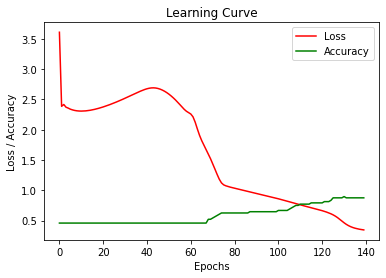

In [ ]:
#Plot a graph of Loss/ Acuracy against Epochs
plt.plot(iterations, loss_list, color='r', label='Loss')
plt.plot(iterations, accuracy_list, color='g', label='Accuracy')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()

In [ ]:
y = np.array(y_test.T) 
x = np.array(X_test.T)
k = 72

In [ ]:
z = np.dot(np.transpose(W), x) + b
y_hat = sigm(z)
cost = loss(k, y_hat, y)   
y_hat = np.where(y_hat >= 0.5, 1, y_hat)
y_hat = np.where(y_hat < 0.5, 0, y_hat)

In [ ]:
accuracy = skl.metrics.accuracy_score(y_test, y_hat.T)

In [ ]:
print(accuracy*100)

95.83333333333334


In [ ]:
################################################################################################################################
#Using the Keras Model

In [ ]:
(train_data, train_targets), (test_data, test_targets) = (X_train, y_train), (X_test, y_test)
print(train_data.shape)

(288, 6200)


In [ ]:
#### Lets look at the data
train_data.shape

(288, 6200)

In [ ]:
test_data.shape

(72, 6200)

In [ ]:
from keras import models
from keras import layers
def build_model():
    model=models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                          input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mse', 'mae', 'accuracy'])
    return model

In [ ]:
import numpy as np
k = 4
num_val_samples = len(train_data) // k
all_mse_histories = []
num_epochs = 30
all_scores = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
# Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    
    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    # Evaluate the model on the validation data
    a, b, val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)
    
    history = model.fit(batch_X_train, batch_y_train, 
                        validation_data=(val_X_train, val_y_train), epochs=num_epochs, 
                        batch_size=1, verbose=0)
    mse_history = history.history['mse'] #Tracked for purpose of graph plot
    all_mse_histories.append(mse_history) #Tracked for purpose of graph plot          
      

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


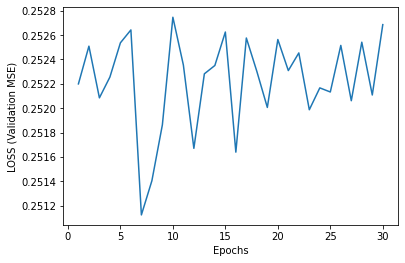

In [ ]:
#Plot a graph of Loss (Mean Square Error) against Epochs
average_mse_history =[np.mean([x[i] for x in all_mse_histories]) for i in range(num_epochs)]
plt.plot(range(1, len(average_mse_history) + 1), average_mse_history)
plt.xlabel('Epochs')
plt.ylabel('LOSS (Validation MSE)')
plt.show()

In [ ]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

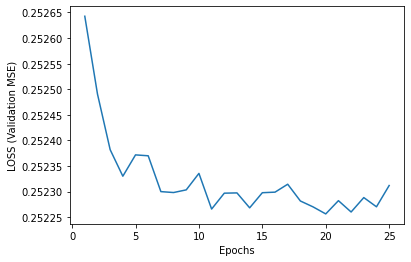

In [ ]:
#Make the graph smoother
smooth_mse_history = smooth_curve(average_mse_history[5:])
plt.plot(range(1, len(smooth_mse_history) + 1), smooth_mse_history)
plt.xlabel('Epochs')
plt.ylabel('LOSS (Validation MSE)')
plt.show()

In [ ]:
print('Training Accuracy on Validation Data: %.2f' % (history.history['val_accuracy'][-1]*100))

Training Accuracy on Validation Data: 45.83


In [ ]:
#Compute Model accuracy on unseen test data
a, test_mse_score, test_mae_score, test_accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (test_accuracy*100))

3/3 [==============================] - 0s 8ms/step - loss: 0.2500 - mse: 0.2500 - mae: 0.5000 - accuracy: 0.5000
Accuracy: 50.00
